### Training model

- Decide which feature to use(just try first)
- Split training data to training data set and validation data set
- Select serval models to train
- Generate submission file (change column name 'date' back to 'day' before submission)


### Feature explanation

- year, year of data
- month, month of year 
- day, day of month
- hour, hour of day from 0 ~ 23
- weekday, week of day from 0 to 6, 0 is Mon, 1 is Tue, 2 is Wed etc.
- grid_id, grid id defined in grid info
- temperture, temperture at given time
- rainy, 0 means no rain, 1 means is rainy
- holiday, 0 means working day, 1 means holiday
- car_number, number of cars in that grid at given time

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import timeit
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
%matplotlib inline


training_features_filepath = 'data/training.csv'
test_features_filepath = 'data/test.csv'
submission_filepath = 'data/submit_samples.csv'
lgb_submission_filepath = 'data/submission_lgb.csv'
xgb_submission_filepath = 'data/submission_xgb.csv'
ann_submission_filepath = 'data/submission_ann.csv'
final_submission_filepath = 'data/submission_final.csv'

training_features_xgb_filepath = 'data/training_xgb.csv'
test_features_xgb_filepath = 'data/test_xgb.csv'

training_features_lgb_filepath = 'data/training_lgb.csv'
test_features_lgb_filepath = 'data/test_lgb.csv'

drop_columns = ['car_number','year']

one_hot_encoding_columns = ['weekday','grid_id','holiday','rainy']

# loading data
train = pd.read_csv(training_features_filepath)
#train = pd.get_dummies(train, columns=one_hot_encoding_columns)
train.head()

,year,month,day,hour,weekday,grid_id,temperture,rainy,holiday,car_number
0,2017,1,2,9,0,1,13,0,1,20.0
1,2017,1,2,9,0,2,13,0,1,7.0
2,2017,1,2,9,0,3,13,0,1,4.0
3,2017,1,2,9,0,4,13,0,1,3.0
4,2017,1,2,9,0,6,13,0,1,9.0


In [46]:
test = pd.read_csv(test_features_filepath)
#test = pd.get_dummies(test, columns=one_hot_encoding_columns)
test.head()

,year,month,day,hour,weekday,grid_id,temperture,rainy,holiday,car_number
0,2017,3,13,9,0,1,9,1,0,0
1,2017,3,13,9,0,2,9,1,0,0
2,2017,3,13,9,0,3,9,1,0,0
3,2017,3,13,9,0,4,9,1,0,0
4,2017,3,13,9,0,5,9,1,0,0


In [47]:
def retrieve_index_by_month_day_hour(df, month, day, hour):
    month = df[df['month'] == month]
    day = month[month['day'] == day]
    hour = day[day['hour'] == hour]
    return hour.index[0]

def generate_submission_file(pred, output_filepath):
    sample_df = pd.read_csv(submission_filepath)
    sample_df['car_number'] = pred
    sample_df['car_number'] = sample_df['car_number'].apply(lambda x : np.ceil(x))
    sample_df['car_number'] = sample_df['car_number'].astype(int)
    sample_df.columns = ['grid_id','day','hour','car_number']
    sample_df.to_csv(output_filepath, index=False)

def split_train_val_data(index, train):
    # split train and val by index
    train_ = train.iloc[:index]
    val_ = train.iloc[index:-1]
    # extract x and y
    train_x = train_.drop(columns=drop_columns)
    train_y = train_['car_number']
    val_x = val_.drop(columns=drop_columns)
    val_y = val_['car_number']
    return train_x, train_y, val_x, val_y

def val_or_generate_submission_file_xgb(param_dict, train, test, index, t='train'):
    regressor = xgb.XGBRegressor(**param_dict)        
    # only train and validate
    if t == 'train':
        # train with part of data
        train_x, train_y, val_x, val_y = split_train_val_data(index, train)
        regressor.fit(train_x.as_matrix(), train_y)
        pred = regressor.predict(val_x.as_matrix())
        print("score is ", np.sqrt(mean_squared_error(val_y, pred)))
    # using predition as a extra feature
    elif t == 'extract':
        train_x = train.drop(columns=drop_columns)
        train_y = train['car_number']
        regressor.fit(train_x.as_matrix(), train_y)
        test_ = test.drop(columns=drop_columns)
        pred = regressor.predict(test_.as_matrix())
        # extract new feature to test
        test['xgb'] = np.ceil(pred)
        test.to_csv(test_features_xgb_filepath, index=False)
        # extract new feature to train
        pred = regressor.predict(train_x.as_matrix())
        train['xbg'] = np.ceil(pred)
        train.to_csv(training_features_xgb_filepath, index=False)        
    # using the whole data set to train and do prediction
    else:
        print("Train with all the data and generate submission file")
        # train with all the data
        train_x = train.drop(columns=drop_columns)
        train_y = train['car_number']
        regressor.fit(train_x.as_matrix(), train_y)
        test_ = test.drop(columns=drop_columns)
        pred = regressor.predict(test_.as_matrix())
        generate_submission_file(pred, xgb_submission_filepath)
        
        
def val_or_generate_submission_file_lgbm(param_dict, n_estimators, train, test, index, t='train'):
    # only train and validate
    if t == 'train':
        # train with part of data
        train_x, train_y, val_x, val_y = split_train_val_data(index, train)
        d_train = lgb.Dataset(train_x, label=train_y)
        d_valid = lgb.Dataset(val_x, label=val_y)
        watchlist = [d_valid]    
        model = lgb.train(param_dict, d_train, n_estimators, watchlist, verbose_eval=0)
        pred = model.predict(val_x)
        print("score is ", np.sqrt(mean_squared_error(val_y, pred)))
    # using predition as a extra feature
    elif t == 'extract':
        train_x = train.drop(columns=drop_columns)
        train_y = train['car_number']
        d_train = lgb.Dataset(train_x, label=train_y)
        model = lgb.train(param_dict, d_train, n_estimators, verbose_eval=0)
        test_ = test.drop(columns=drop_columns)
        # extract predition to test
        pred = model.predict(test_)
        test['lgb'] = np.ceil(pred)
        test.to_csv(test_features_lgb_filepath, index=False)
        # extract prediction to train
        pred = model.predict(train_x)
        train['lgb'] = np.ceil(pred)
        train.to_csv(training_features_lgb_filepath, index=False)        
    # using the whole data set to train and do prediction
    else:
        print("Train with all the data and generate submission file")
        # train with all the data
        train_x = train.drop(columns=drop_columns)
        train_y = train['car_number']
        d_train = lgb.Dataset(train_x, label=train_y)
        model = lgb.train(param_dict, d_train, n_estimators, verbose_eval=0)
        test_ = test.drop(columns=drop_columns)
        pred = model.predict(test_)
        generate_submission_file(pred, lgb_submission_filepath)
        
def plot_model(history):
    train_loss = history.history['loss']
    #train_acc = history.history['acc']
    val_loss = history.history['val_loss']
    #val_acc = history.history['val_acc']

    niter = np.arange(len(train_loss))

    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

    ax1.plot(niter, train_loss, label='train')
    ax1.plot(niter, val_loss, label='validation')
    ax1.set_title("loss")
    ax1.set_xlabel('ecphos')
    ax1.set_ylabel('loss')
    #ax1.set_ylim(0, 100)

    #ax2.plot(niter, train_acc, label='train')
    #ax2.plot(niter, val_acc, label='validation')
    #ax2.set_title("accuracy")
    #ax2.set_xlabel('ecphos')
    #ax2.set_ylabel('accuracy')
    #ax2.set_ylim(0.85, 1)

    plt.legend()
    plt.show()

### TODOs

- Try use ceil instead of round. **Done test score : 8.0536**
- Try remove wind and visibitly and make a submission. **Done test score : 8.0266**
- Add average speed as grid feature and make a submission **Done test socre: 8.058**
- Add missing data and set car number to average via ceil **Done test socre: 8.0373**
- Add missing data and set car number to average via round **Done test socre: 8.0484**
- Try LGB and make a submission **Done test socre: 8.0091**
- Try filter invalid date in each csv and make a submission via LGB **Done test socre: 8.0012**
- Adding avg,std,median car number to features and make a submission via LGB **Done test socre: 8.1684**
- Remove outliers and make a submission via LGB **Done test socre: 8.0288**
- Try NN or LSTM and make a submission (2018-09-xx)
- Try ensemble learning and stacking models (2018-09-xx)
- Plot 50 grids on map and see if can find more features for grid (2018-09-xx)


### XGB Model 1 - Extract feature

In [47]:
param_dict = {
    'max_depth' : 5,
    'learning_rate' : 0.01,
    'n_estimators' : 1500,
    'silent' : True,
    'objective' : 'reg:linear',
    'booster' : 'gbtree',
    'n_jobs' : 8,
    'gamma' : 0,
    'min_child_weight' : 1,
    'max_delta_step' : 0,
    'subsample' : 0.75,
    'colsample_bytree' : 0.9,
    'reg_alpha' : 0.7,
    'reg_lambda' : 1
}
index = retrieve_index_by_month_day_hour(train, 3, 6, 9)
val_or_generate_submission_file_xgb(param_dict, train, test, index, 'extract')
#val_or_generate_submission_file_xgb(param_dict, train, test, index)

### Light GBM Model 1 - Extract feature

In [48]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'n_jobs': 8,
    'metric': 'rmse',
    'max_depth': 5,
    'learning_rate': 0.01,
    'verbose': 0}

n_estimators = 4750
# reloading data
train = pd.read_csv(training_features_xgb_filepath)
test = pd.read_csv(test_features_xgb_filepath)
index = retrieve_index_by_month_day_hour(train, 3, 6, 9)
val_or_generate_submission_file_lgbm(params, n_estimators, train, test, index, 'extract')
#val_or_generate_submission_file_lgbm(params, n_estimators, train, test, index)

### XGB Model 2 - Prediction

In [16]:
param_dict = {
    'max_depth' : 9,
    'learning_rate' : 0.01,
    'n_estimators' : 1500,
    'silent' : True,
    'objective' : 'reg:linear',
    'booster' : 'gbtree',
    'n_jobs' : 8,
    'gamma' : 0,
    'min_child_weight' : 1,
    'max_delta_step' : 0,
    'subsample' : 0.75,
    'colsample_bytree' : 0.9,
    'reg_alpha' : 0.7,
    'reg_lambda' : 1
}
# loading train and test set with xgb and lgb features
#train = pd.read_csv(training_features_lgb_filepath)
#test = pd.read_csv(test_features_lgb_filepath)
# predict
index = retrieve_index_by_month_day_hour(train, 3, 6, 9)
val_or_generate_submission_file_xgb(param_dict, train, test, index,'') # 3.369559474786608 3.362073701927338

Train with all the data and generate submission file


### Light GBM Model 2 - Prediction

In [17]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'n_jobs': 8,
    'metric': 'rmse',
    'max_depth': 7,
    'learning_rate': 0.01,
    'verbose': 0}

n_estimators = 4750
# loading train and test set with xgb and lgb features
#train = pd.read_csv(training_features_lgb_filepath)
#test = pd.read_csv(test_features_lgb_filepath)
# prediction
index = retrieve_index_by_month_day_hour(train, 3, 6, 9)
val_or_generate_submission_file_lgbm(params, n_estimators, train, test, index,'') # 3.3073688776246732 3.289658603021144

Train with all the data and generate submission file


### ANN Model

In [89]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Embedding
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler

# loading train and test data set
train = pd.read_csv(training_features_filepath)
test = pd.read_csv(test_features_filepath)

# retrieve length of train data for later use
train_idx = train.shape[0]

# retrieve target
train_y = train['car_number']

# drop uncessary columns
train = train.drop(columns=drop_columns)
test = test.drop(columns=drop_columns)

# merging train and test
data = train.append(test)

# one hot encoding
data = pd.get_dummies(data, columns=one_hot_encoding_columns)

# normalization
scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)

# split train and test
train_x = data[:train_idx]
test_x = data[train_idx:-1]

# adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


model = Sequential()
#model.add(Embedding(train_x.shape[1] + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Dense(256, input_shape=(train_x.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 256)               16896     
_________________________________________________________________
batch_normalization_28 (Batc (None, 256)               1024      
_________________________________________________________________
dense_51 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_29 (Batc (None, 512)               2048      
_________________________________________________________________
dense_52 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_30 (Batc (None, 256)               1024      
_________________________________________________________________
dense_53 (Dense)             (None, 128)               32896     
__________

In [24]:
# fit data
history = model.fit(X_train, y_train, epochs=500, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Train on 38654 samples, validate on 4834 samples
Epoch 1/500
38654/38654 [==============================] - 5s 126us/step - loss: 186.0808 - val_loss: 222.3218
Epoch 2/500
38654/38654 [==============================] - 0s 10us/step - loss: 168.7250 - val_loss: 209.4016
Epoch 3/500
38654/38654 [==============================] - 0s 10us/step - loss: 151.1661 - val_loss: 186.1636
Epoch 4/500
38654/38654 [==============================] - 0s 10us/step - loss: 134.5292 - val_loss: 157.0854
Epoch 5/500
38654/38654 [==============================] - 0s 10us/step - loss: 118.3973 - val_loss: 133.1351
Epoch 6/500
38654/38654 [==============================] - 0s 10us/step - loss: 103.4770 - val_loss: 117.0067
Epoch 7/500
38654/38654 [==============================] - 0s 10us/step - loss: 92.0962 - val_loss: 104.7356
Epoch 8/500
38654/38654 [==============================] - 0s 10us/step - loss: 83.2154 - val_loss: 94.9523
Epoch 9/500
38654/38654 [==============================] - 0s 10us/step -

Epoch 150/500
38654/38654 [==============================] - 0s 10us/step - loss: 51.0023 - val_loss: 58.8624
Epoch 151/500
38654/38654 [==============================] - 0s 10us/step - loss: 50.6849 - val_loss: 58.5410
Epoch 152/500
38654/38654 [==============================] - 0s 10us/step - loss: 50.9545 - val_loss: 58.2034
Epoch 153/500
38654/38654 [==============================] - 0s 10us/step - loss: 50.7819 - val_loss: 58.0467
Epoch 154/500
38654/38654 [==============================] - 0s 10us/step - loss: 50.5361 - val_loss: 58.0706
Epoch 155/500
38654/38654 [==============================] - 0s 10us/step - loss: 50.6498 - val_loss: 58.4515
Epoch 156/500
38654/38654 [==============================] - 0s 9us/step - loss: 50.6721 - val_loss: 58.2393
Epoch 157/500
38654/38654 [==============================] - 0s 10us/step - loss: 50.6564 - val_loss: 58.0964
Epoch 158/500
38654/38654 [==============================] - 0s 10us/step - loss: 50.6511 - val_loss: 57.9524
Epoch 159/5

Epoch 299/500
38654/38654 [==============================] - 0s 10us/step - loss: 49.0459 - val_loss: 56.3816
Epoch 300/500
38654/38654 [==============================] - 0s 9us/step - loss: 49.1490 - val_loss: 56.4597
Epoch 301/500
38654/38654 [==============================] - 0s 9us/step - loss: 49.2208 - val_loss: 56.3481
Epoch 302/500
38654/38654 [==============================] - 0s 10us/step - loss: 49.2769 - val_loss: 56.3070
Epoch 303/500
38654/38654 [==============================] - 0s 10us/step - loss: 49.0339 - val_loss: 57.0967
Epoch 304/500
38654/38654 [==============================] - 0s 9us/step - loss: 49.0961 - val_loss: 56.4147
Epoch 305/500
38654/38654 [==============================] - 0s 9us/step - loss: 49.2846 - val_loss: 56.4735
Epoch 306/500
38654/38654 [==============================] - 0s 9us/step - loss: 49.2636 - val_loss: 56.3528
Epoch 307/500
38654/38654 [==============================] - 0s 9us/step - loss: 49.1285 - val_loss: 56.6174
Epoch 308/500
38

Epoch 374/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.4764 - val_loss: 57.0488
Epoch 375/500
38654/38654 [==============================] - 0s 10us/step - loss: 48.7065 - val_loss: 56.7651
Epoch 376/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.5856 - val_loss: 56.6583
Epoch 377/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.9281 - val_loss: 58.0840
Epoch 378/500
38654/38654 [==============================] - 0s 10us/step - loss: 49.0592 - val_loss: 57.3477
Epoch 379/500
38654/38654 [==============================] - 0s 10us/step - loss: 48.7045 - val_loss: 56.5522
Epoch 380/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.5170 - val_loss: 56.5770
Epoch 381/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.7658 - val_loss: 57.2235
Epoch 382/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.4349 - val_loss: 56.5390
Epoch 383/500
38

Epoch 449/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.1834 - val_loss: 57.9617
Epoch 450/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.4357 - val_loss: 56.6495
Epoch 451/500
38654/38654 [==============================] - 0s 10us/step - loss: 48.6077 - val_loss: 57.5011
Epoch 452/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.4498 - val_loss: 58.5020
Epoch 453/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.2814 - val_loss: 56.9057
Epoch 454/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.3235 - val_loss: 58.0737
Epoch 455/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.3369 - val_loss: 57.2588
Epoch 456/500
38654/38654 [==============================] - 0s 9us/step - loss: 48.4171 - val_loss: 57.9995
Epoch 457/500
38654/38654 [==============================] - 0s 10us/step - loss: 48.2770 - val_loss: 57.6253
Epoch 458/500
386

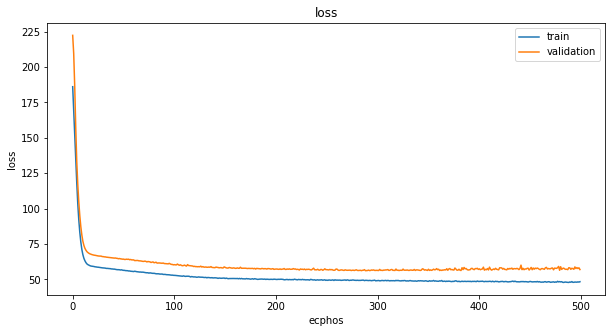

In [25]:
plot_model(history)

In [91]:
print(train_x.shape, train_y.shape)

(43489, 65) (43489,)


In [92]:
# fit the whole data set
model.fit(train_x, train_y, epochs=50, batch_size=128, verbose=1)

Epoch 1/50
43489/43489 [==============================] - 3s 73us/step - loss: 24.0457
Epoch 2/50
43489/43489 [==============================] - 2s 45us/step - loss: 14.9626
Epoch 3/50
43489/43489 [==============================] - 2s 46us/step - loss: 14.1951
Epoch 4/50
43489/43489 [==============================] - 2s 45us/step - loss: 13.6794
Epoch 5/50
43489/43489 [==============================] - 2s 45us/step - loss: 13.3169
Epoch 6/50
43489/43489 [==============================] - 2s 46us/step - loss: 13.0003
Epoch 7/50
43489/43489 [==============================] - 2s 45us/step - loss: 12.7298
Epoch 8/50
43489/43489 [==============================] - 2s 46us/step - loss: 12.5208
Epoch 9/50
43489/43489 [==============================] - 2s 46us/step - loss: 12.3253
Epoch 10/50
43489/43489 [==============================] - 2s 46us/step - loss: 12.2715
Epoch 11/50
43489/43489 [==============================] - 2s 47us/step - loss: 12.0261
Epoch 12/50
43489/43489 [================

In [14]:
# predit and generate submission file
pred = model.predict(x_test)
generate_submission_file(pred, ann_submission_filepath)

### Averaging prediction

In [19]:
# loading prediction file
xgb_pred = pd.read_csv(xgb_submission_filepath)
lgb_pred = pd.read_csv(lgb_submission_filepath)
# rename car_number
xgb_pred = xgb_pred.rename(columns={'car_number': 'car_number_xgb'})
lgb_pred = lgb_pred.rename(columns={'car_number': 'car_number_lgb'})
# merge 2 dataframes
avg_sub = pd.merge(xgb_pred, lgb_pred, on=['grid_id','day','hour'], how='left')
avg_sub['car_number'] = 0
avg_sub['car_number'] = np.ceil((avg_sub.car_number_xgb + avg_sub.car_number_lgb) * 1.05 /2)
avg_sub = avg_sub.drop(columns=['car_number_xgb', 'car_number_lgb'])
avg_sub.to_csv(final_submission_filepath, index=False)

### LSTM Model (TODO)

In [56]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

train_grid_id_1 = train[train['grid_id']==1]
train_grid_id_1 = train_grid_id_1.reset_index()
index = retrieve_index_by_month_day_hour(train_grid_id_1, 3, 6, 9)
train_x, train_y, val_x, val_y = split_train_val_data(index, train_grid_id_1)

train_x = train_x.drop(columns=['grid_id'])
val_x = val_x.drop(columns=['grid_id'])

min_max_scaler = MinMaxScaler()
train_x = min_max_scaler.fit_transform(train_x)
val_x = min_max_scaler.fit_transform(val_x)

train_x = np.reshape(train_x, (1, 784, 8))
val_x = np.reshape(val_x, (1, 97, 8))

lstm = Sequential()
lstm.add(LSTM(20, dropout=0.1, recurrent_dropout=0.1, input_shape=(784, 8), return_sequences=True))
lstm.add(LSTM(10, dropout=0.1, recurrent_dropout=0.1))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

lstm.summary()

#lstm.fit(train_x, train_y, epochs=100, batch_size=1, validation_data=(val_x, val_y), verbose=1)
#score, mse = lstm.evaluate(val_x, val_y, batch_size=1)
#print(score + ", " + mse)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 784, 20)           2320      
_________________________________________________________________
lstm_22 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 3,571
Trainable params: 3,571
Non-trainable params: 0
_________________________________________________________________
